# Базовий фреймворк для задач задоволення обмежень

Базова модель задачі задоволення обмежень:

In [158]:
# csp.py
# From Classic Computer Science Problems in Python Chapter 3
# Copyright 2018 David Kopec
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type


# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...


# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables # variables to be constrained
        self.domains: Dict[V, List[D]] = domains # domain of each variable
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # get all variables in the CSP but not in the assignment
        unassigned: List[V] = [v for v in self.variables if v not in assignment]

        # get the every possible domain value of the first unassigned variable
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we didn't find the result, we will end up backtracking
                if result is not None:
                    return result
        return None
    

Базовий метод - пошук з поверненнями(backtracking):

# Задача розфарбовування карти

Реалізація обмеження задачі:

In [159]:
class MapColoringConstraint(Constraint[str, str]):
    def __init__(self, place1: str, place2: str) -> None:
        super().__init__([place1, place2])
        self.place1: str = place1
        self.place2: str = place2

    def satisfied(self, assignment: Dict[str, str]) -> bool:
        # If either place is not in the assignment then it is not
        # yet possible for their solution to be conflicting
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        # check the color assigned to place1 is not the same as the
        # color assigned to place2
        return assignment[self.place1] != assignment[self.place2]

Рішення для Австралії:

In [160]:
variables: List[str] = ["WA", "NT", "SA", "Q", "NSW", "V", "T"]
domains: Dict[str, List[str]] = {}
for variable in variables:
    domains[variable] = ["red", "green", "blue", "pink"]
csp: CSP[str, str] = CSP(variables, domains)
csp.add_constraint(MapColoringConstraint("WA", "NT"))
csp.add_constraint(MapColoringConstraint("WA", "SA"))
csp.add_constraint(MapColoringConstraint("SA", "NT"))
csp.add_constraint(MapColoringConstraint("Q", "NT"))
csp.add_constraint(MapColoringConstraint("Q", "SA"))
csp.add_constraint(MapColoringConstraint("Q", "NSW"))
csp.add_constraint(MapColoringConstraint("NSW", "SA"))
csp.add_constraint(MapColoringConstraint("V", "SA"))
csp.add_constraint(MapColoringConstraint("V", "NSW"))
csp.add_constraint(MapColoringConstraint("V", "T"))
solution: Optional[Dict[str, str]] = csp.backtracking_search()
if solution is None:
    print("No solution found!")
else:
    print(solution)

{'WA': 'red', 'NT': 'green', 'SA': 'blue', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'T': 'green'}


{'Hauts-de-France': 'red', 'Normandie': 'green', 'Ile-de-France': 'yellow', 'Grand-Est': 'green', 'Bretagne': 'red', 'Pays-de-la-Loire': 'yellow', 'Centre-Val de Loire': 'red', 'Bourgone-Franche-comte': 'pink', 'Nouvelle-Aquitaine': 'green', 'Auvergne-Rhone-Alpes': 'yellow', 'Occitanle': 'red', "Provence-Alpes-Cote d'Azur": 'green', 'Corsica': 'red'}


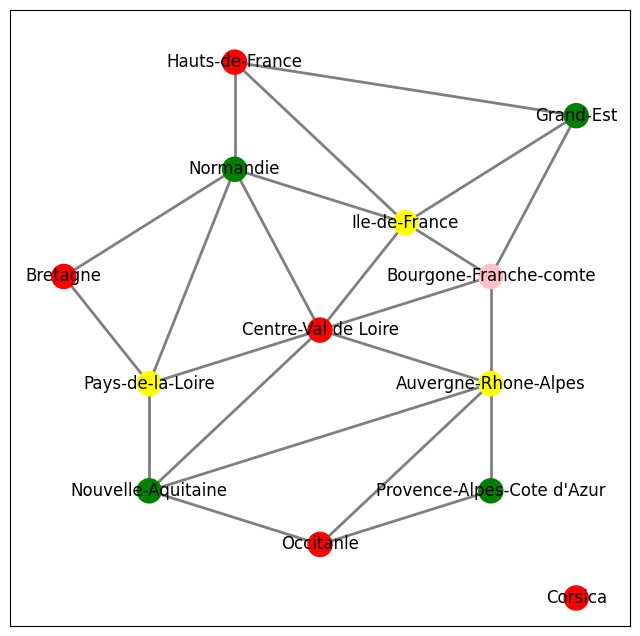

In [161]:
import networkx as nx
import matplotlib.pyplot as plt

class CSPBeamSearch(CSP[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]], beam_width: int) -> None:
        super().__init__(variables, domains)
        self.beam_width = beam_width

    def heuristic(self, assignment: Dict[V, D]) -> int:
        num_conflicts = 0
        for variable in assignment:
            for constraint in self.constraints[variable]:
                if not constraint.satisfied(assignment):
                    num_conflicts += 1
        return num_conflicts

    def beam_search(self) -> Optional[Dict[V, D]]:
        assignments = [{}]

        while assignments:
            new_assignments = []
            for assignment in assignments:
                if len(assignment) == len(self.variables):
                    return assignment
                
                unassigned = [v for v in self.variables if v not in assignment]
                variable = unassigned[0]

                for value in self.domains[variable]:
                    new_assignment = assignment.copy()
                    new_assignment[variable] = value
                    if self.consistent(variable, new_assignment):
                        new_assignments.append(new_assignment)

            new_assignments.sort(key=self.heuristic)
            assignments = new_assignments[:self.beam_width]

        return None

variables: List[str] = [
    'Hauts-de-France', 'Normandie', 'Ile-de-France', 'Grand-Est', 'Bretagne', 
    'Pays-de-la-Loire', 'Centre-Val de Loire', 'Bourgone-Franche-comte', 
    'Nouvelle-Aquitaine', 'Auvergne-Rhone-Alpes', 'Occitanle', 
    'Provence-Alpes-Cote d\'Azur', 'Corsica'
]
domains: Dict[str, List[str]] = {}
for variable in variables:
    domains[variable] = ["red", "green", "yellow", "pink"]

csp: CSPBeamSearch[str, str] = CSPBeamSearch(variables, domains, beam_width=10)

edges = [
    ('Hauts-de-France', 'Normandie'),
    ('Hauts-de-France', 'Ile-de-France'),
    ('Hauts-de-France', 'Grand-Est'),
    ('Normandie', 'Ile-de-France'),
    ('Normandie', 'Bretagne'),
    ('Normandie', 'Pays-de-la-Loire'),
    ('Normandie', 'Centre-Val de Loire'),
    ('Ile-de-France', 'Grand-Est'),
    ('Ile-de-France', 'Centre-Val de Loire'),
    ('Ile-de-France', 'Bourgone-Franche-comte'),
    ('Grand-Est', 'Bourgone-Franche-comte'),
    ('Pays-de-la-Loire', 'Bretagne'),
    ('Pays-de-la-Loire', 'Nouvelle-Aquitaine'),
    ('Pays-de-la-Loire', 'Centre-Val de Loire'),
    ('Centre-Val de Loire', 'Bourgone-Franche-comte'),
    ('Centre-Val de Loire', 'Auvergne-Rhone-Alpes'),
    ('Centre-Val de Loire', 'Nouvelle-Aquitaine'),
    ('Bourgone-Franche-comte', 'Auvergne-Rhone-Alpes'),
    ('Nouvelle-Aquitaine', 'Auvergne-Rhone-Alpes'),
    ('Nouvelle-Aquitaine', 'Occitanle'),
    ('Auvergne-Rhone-Alpes', 'Occitanle'),
    ('Auvergne-Rhone-Alpes', 'Provence-Alpes-Cote d\'Azur'),
    ('Occitanle', 'Provence-Alpes-Cote d\'Azur'),
]

for edge in edges:
    csp.add_constraint(MapColoringConstraint(*edge))

solution: Optional[Dict[str, str]] = csp.beam_search()
if solution is None:
    print("No solution found!")
else:
    print(solution)
    G = nx.Graph()
    for node, color in solution.items():
        G.add_node(node, color=color)

    G.add_edges_from(edges)

    pos = nx.spring_layout(G)

    pos = {
        'Hauts-de-France': [0.3, 1.2],
        'Normandie': [0.3, 1],
        'Ile-de-France': [0.5, 0.9],
        'Grand-Est': [0.7, 1.1],
        'Bretagne': [0.1, 0.8],
        'Pays-de-la-Loire': [0.2, 0.6],
        'Centre-Val de Loire': [0.4, 0.7],
        'Bourgone-Franche-comte': [0.6, 0.8],
        'Nouvelle-Aquitaine': [0.2, 0.4],
        'Auvergne-Rhone-Alpes': [0.6, 0.6],
        'Occitanle': [0.4, 0.3],
        'Provence-Alpes-Cote d\'Azur': [0.6, 0.4], 
        'Corsica': [0.7, 0.2]
    }

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color=[solution[n] for n in G.nodes])
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    plt.show()



# Задача з ферзями

Реалізація обмеження задачі:

In [162]:
class QueensConstraint(Constraint[int, int]):
    def __init__(self, columns: List[int]) -> None:
        super().__init__(columns)
        self.columns: List[int] = columns

    def satisfied(self, assignment: Dict[int, int]) -> bool:
        # q1c = queen 1 column, q1r = queen 1 row
        for q1c, q1r in assignment.items():
            # q2c = queen 2 column
            for q2c in range(q1c + 1, len(self.columns) + 1):
                if q2c in assignment:
                    q2r: int = assignment[q2c] # q2r = queen 2 row
                    if q1r == q2r: # same row?
                        return False
                    if abs(q1r - q2r) == abs(q1c - q2c): # same diagonal?
                        return False
        return True # no conflict

Рішення:

In [163]:
    columns: List[int] = [1, 2, 3, 4, 5, 6, 7, 8]
    rows: Dict[int, List[int]] = {}
    for column in columns:
        rows[column] = [1, 2, 3, 4, 5, 6, 7, 8]
    csp: CSP[int, int] = CSP(columns, rows)
    csp.add_constraint(QueensConstraint(columns))
    solution: Optional[Dict[int, int]] = csp.backtracking_search()
    if solution is None:
        print("No solution found!")
    else:
        print(solution)

{1: 1, 2: 5, 3: 8, 4: 6, 5: 3, 6: 7, 7: 2, 8: 4}
